In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [29]:
data= pd.read_csv("online_retail.csv")

In [30]:
#data.isnull().sum()  (Missing_Values , Decription :1454, CustomerID :135080)
data =data.dropna() # remove Missing Values
data.drop_duplicates(inplace=True) #remove duplicate values from data_set
#Filter data with having 0 value in Quanity and Unitprice Column
data =data[(data["UnitPrice"] >0) | (data["Quantity"]>0 ) ]
#remove all of the cancelled invoices like C503056 (prefix by "C")
data =data[~data.InvoiceNo.str.contains("C")]

##### FEATURE ENGINEERING

In [31]:
#Update data type of InvoiceDate column
data["InvoiceDate"]=pd.to_datetime(data["InvoiceDate"])

In [32]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### COHORT ANALYSIS & CUSTOMER SEGMENTATION
##### For cohort analysis, there are a few labels that we have to create:

##### Invoice period: A string representation of the year and month of a single transaction/invoice.
##### Cohort group: A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
##### Cohort period / Cohort Index: A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [33]:
data["Inv_Month"] = data["InvoiceDate"].apply(lambda x : dt(x.year,x.month,1))
#cohortmonth - date on which individual customer first purchased
group =data.groupby("CustomerID")["Inv_Month"]
data["CohortMonth"]=group.transform('min')
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Inv_Month,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [34]:
#Calcuate cohort index  its represent number of months passed since the first purchase.
# function to get year, month,day

def get_year_month (dataframe,column_name):
    year = dataframe[column_name].dt.year
    month = dataframe[column_name].dt.month
    return year, month

invoice_year,invoice_month = get_year_month(data,"InvoiceDate")
cohort_year,cohort_month = get_year_month(data,"CohortMonth")
year_diff =invoice_year-cohort_year
month_diff =invoice_month -cohort_month

data["Cohort_INDEX"] = year_diff*12 + month_diff +1
data.head(3)
    

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Inv_Month,CohortMonth,Cohort_INDEX
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [35]:
# count monthly active customers from each cohort

grouping = data.groupby(["CohortMonth","Cohort_INDEX"])
cohort_data = grouping["CustomerID"].apply(pd.Series.nunique)
cohort_data =cohort_data.reset_index()
cohort_data.head()

,CohortMonth,Cohort_INDEX,CustomerID
0,2010-12-01,1,885
1,2010-12-01,2,324
2,2010-12-01,3,286
3,2010-12-01,4,340
4,2010-12-01,5,321


In [36]:
cohort_counts =cohort_data.pivot(index="CohortMonth",columns="Cohort_INDEX",values="CustomerID")
cohort_counts

Cohort_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### COHORT RETENTION RATE
##### Customer Retention is a very useful metric to understand how many of the all customers are still active. Retentio gives you the percentage of active customers compared to the total number of customers.

In [37]:
cohort_size =cohort_counts.iloc[:,0]
cohort_retention = cohort_counts.divide(cohort_size,axis=0)
cohort_retention.round(3)*100   # show value as percentage

Cohort_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


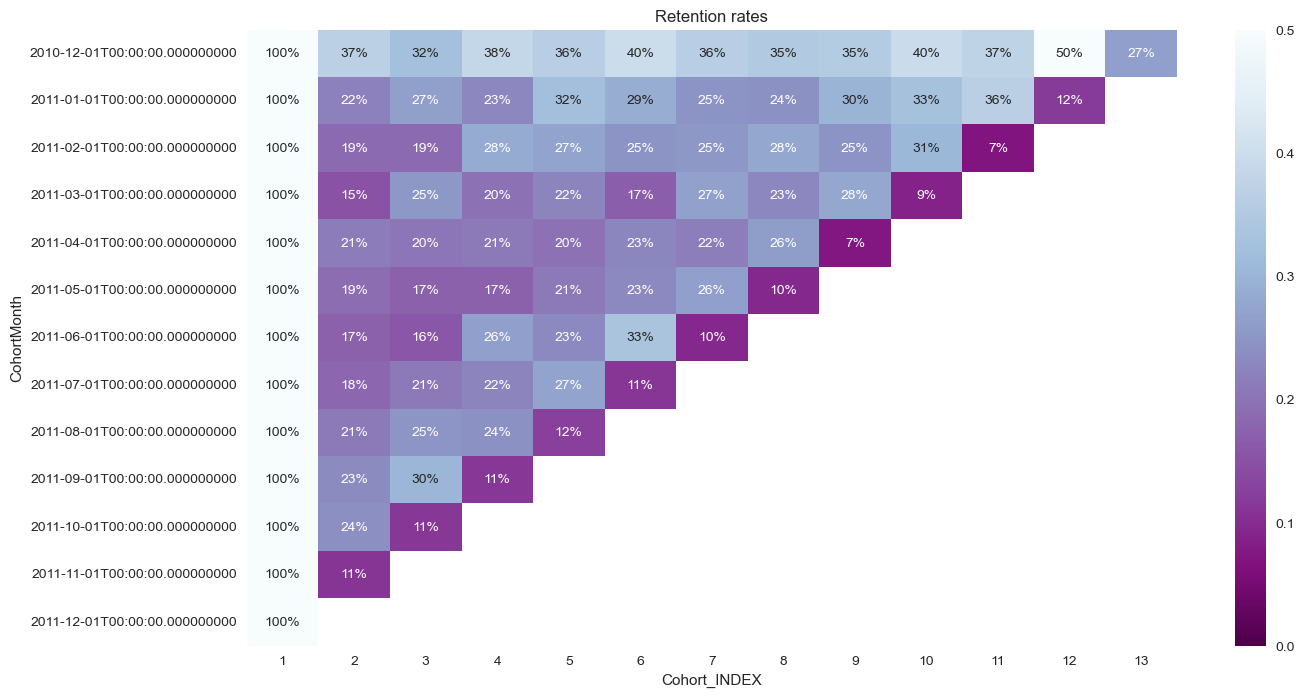

In [26]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=cohort_retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r",annot_kws={"size": 10})
plt.show()

In [39]:
# Average quantity for each cohort 
grp = data.groupby(["CohortMonth","Cohort_INDEX"])
quantity_data =grp["Quantity"].mean()
quantity_data = quantity_data.reset_index()

In [40]:
quantity_data =quantity_data.round(0)

In [41]:
cohort_quantity =quantity_data.pivot(index ="CohortMonth",columns="Cohort_INDEX",values="Quantity" )

<AxesSubplot:xlabel='Cohort_INDEX', ylabel='CohortMonth'>

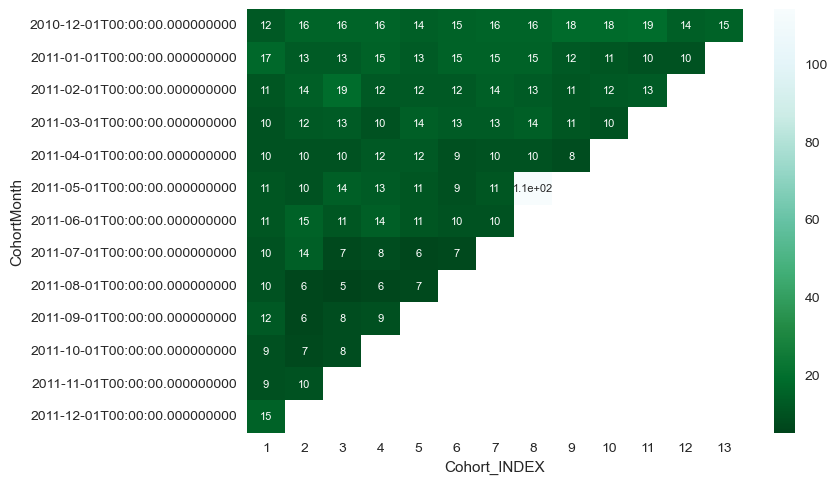

In [42]:
sns.heatmap(data=cohort_quantity,annot=True,cmap='BuGn_r',annot_kws={"size": 8})

In [43]:
data["Revenue"] = data["UnitPrice"]*data["Quantity"]

### Recency, Frequency and Monetary Value calculation
###### What is RFM?
###### * RFM is an acronym of recency, frequency and monetary. 
###### * Recency is about when was the last order of a customer. It means the number of days since a customer made the last purchase. If it’s a case for a website or an app, this could be interpreted as the last visit day or the last login time.

###### * Frequency is about the number of purchase in a given period. It could be 3 months, 6 months or 1 year. So we can understand this value as for how often or how many a customer used the product of a company. The bigger the value is, the more engaged the customers are. Could we say them as our VIP? Not necessary. Cause we also have to think about how much they actually paid for each purchase, which means monetary value.

###### # Monetary is the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers such as MVP or VIP.

###### The RFM values can be grouped in several ways:

###### 1.Percentiles e.g. quantiles

###### 2.Pareto 80/20 cut

###### 3.Custom - based on business knowledge

###### We are going to implement percentile-based grouping.

In [44]:
# Difine Functions to reomove outliers 

def name(dataframe, col):
    q2 =dataframe[col].quantile(0.25)
    q3 =dataframe[col].quantile(0.75)
    iq=q3-q2
    upper_limit = q3 + 1.5 * iq
    lower_limit = q2 - 1.5 * iq
    return upper_limit,lower_limit

#Replace only value which greater than upper_limit. For lower limit we can get negative values if we replace those also.

def rep(dataframe, col):
    up,lw = name(dataframe, col)
    dataframe.loc[(dataframe[col]>up),col] = up

In [ ]:
# Remove outliers from Revenue column
# rep(data,"Revenue")

In [45]:
# In real life we will be working with today or yesterday's date so let take snap_shot date as per the most recent date of dataframe
snap_shot_date =dt(2011,12,12)


In [46]:
RFM_DataFrame=data.groupby("CustomerID").agg({'InvoiceDate' : lambda x : (snap_shot_date-x.max()).days,'InvoiceNo': "count",'Revenue': 'sum'})

In [47]:
#Update Column Names
RFM_DataFrame.columns = ['Recency','Frequency','Monetory']
RFM_DataFrame.reset_index(inplace=True)
RFM_DataFrame['CustomerID']=RFM_DataFrame['CustomerID'].astype('str').apply(lambda x :x[0:-2])
RFM_DataFrame.head()

,CustomerID,Recency,Frequency,Monetory
0,12346,327,1,77183.60
1,12347,4,182,4310.00
2,12348,77,31,1797.24
3,12349,20,73,1757.55
4,12350,312,17,334.40


#### NOTE :
###### We will rate "Recency" customer who have been active more recently better than the less recent customer,because each company wants its customers to be recent

###### We will rate "Frequency" and "Monetary Value" higher label because we want Customer to spend more money and visit more often(that is different order than recency).

In [48]:
#Building RFM segments
r_labels =range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)
r_quartiles = pd.qcut(RFM_DataFrame['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(RFM_DataFrame['Frequency'],q=4, labels = f_labels)
m_quartiles = pd.qcut(RFM_DataFrame['Monetory'],q=4,labels = m_labels)
RFM_DataFrame = RFM_DataFrame.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])
RFM_DataFrame['RFM_Segment'] = RFM_DataFrame.apply(add_rfm,axis=1 )
RFM_DataFrame['RFM_Score'] = RFM_DataFrame[['R','F','M']].sum(axis=1)
RFM_DataFrame.head()

,CustomerID,Recency,Frequency,Monetory,R,F,M,RFM_Segment,RFM_Score
0,12346,327,1,77183.60,1,1,4,114,6
1,12347,4,182,4310.00,4,4,4,444,12
2,12348,77,31,1797.24,2,2,4,224,8
3,12349,20,73,1757.55,3,3,4,334,10
4,12350,312,17,334.40,1,1,2,112,4


In [49]:
#Summary maxtric as per the RFM Score 
RFM_DataFrame.groupby("RFM_Score").agg({'Recency':'mean','Frequency':'mean','Monetory':['mean','count']}).round(1)

Recency Frequency Monetory      
             mean      mean     mean count
RFM_Score                                 
3           262.2       8.2    157.4   381
4           178.0      13.6    239.6   391
5           153.9      21.1    366.8   519
6            97.1      27.9    818.2   461
7            81.6      38.2    762.0   457
8            65.2      56.2    987.3   459
9            47.6      78.9   1804.5   410
10           34.0     110.9   2065.2   428
11           22.6     187.2   4050.3   390
12            8.6     371.0   9393.2   443

In [50]:
# Use RFM to group cutomers inot Bronze, Silve and Gold.
conditions  = [RFM_DataFrame["RFM_Score"]>9,[(RFM_DataFrame['RFM_Score'] > 5) & (RFM_DataFrame['RFM_Score'] <=9)] ,RFM_DataFrame["RFM_Score"]<=5]
values =["GOLD","SILVER", "BRONZE"]
RFM_DataFrame["General_Segment"]=np.select(conditions,values).flatten()
RFM_DataFrame.head()

,CustomerID,Recency,Frequency,Monetory,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,12346,327,1,77183.60,1,1,4,114,6,SILVER
1,12347,4,182,4310.00,4,4,4,444,12,GOLD
2,12348,77,31,1797.24,2,2,4,224,8,SILVER
3,12349,20,73,1757.55,3,3,4,334,10,GOLD
4,12350,312,17,334.40,1,1,2,112,4,BRONZE


In [51]:
#Summary maxtric as per the Cutomer_Segment
RFM_DataFrame.groupby("General_Segment").agg({'Recency':'mean','Frequency':'mean','Monetory':['mean','count']}).round(1)

Recency Frequency Monetory      
                   mean      mean     mean count
General_Segment                                 
BRONZE            193.2      15.0    266.5  1291
GOLD               21.6     225.9   5253.6  1261
SILVER             73.6      49.5   1073.6  1787

#### DATA PRE-PROCESSING K_MEANS CLUSTERING

##### Need to Check following assumption for K-Means Clustering
##### 1 Symmetric distribution of variables (not skewed)
##### 2 Variables with same average values
##### 3 Variables with same variance

c:\Users\kashy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\kashy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\kashy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

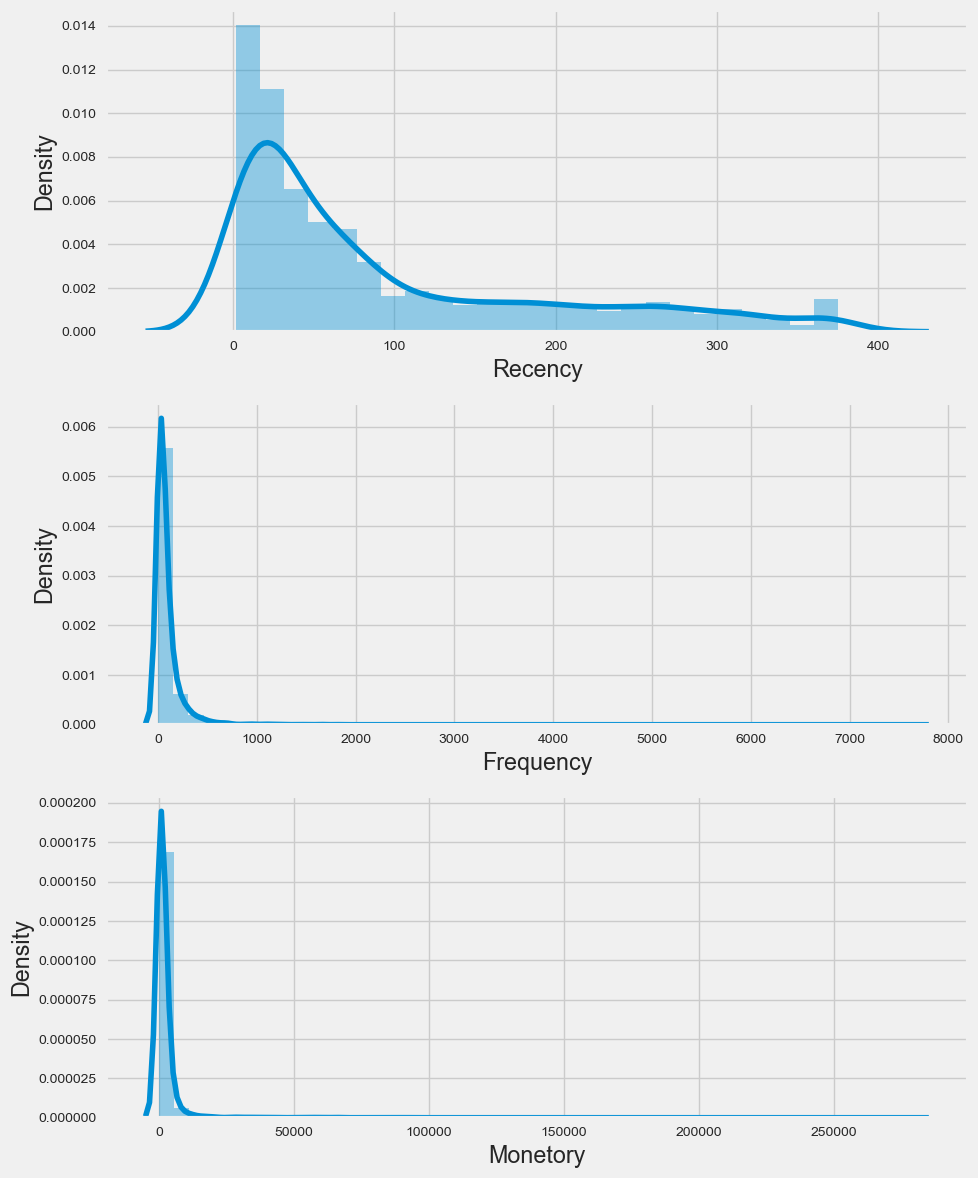

In [73]:
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(RFM_DataFrame.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(RFM_DataFrame.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(RFM_DataFrame.Monetory, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

#### UnSymmetric distribution of variables (data skewed)

##### Solution:Logarithmic transformation (positive values only) will manage skewness
##### We use these Sequence of structuring pre-processing steps:
##### 1. Unskew the data - log transformation
##### 2. Standardize to the same average values
##### 3. Scale to the same standard deviation
##### 4. Store as a separate array to be used for clustering

#### Why the sequence matters?
##### Log transformation only works with positive data
##### Normalization forces data to have negative values and log will not work



c:\Users\kashy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\kashy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\kashy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

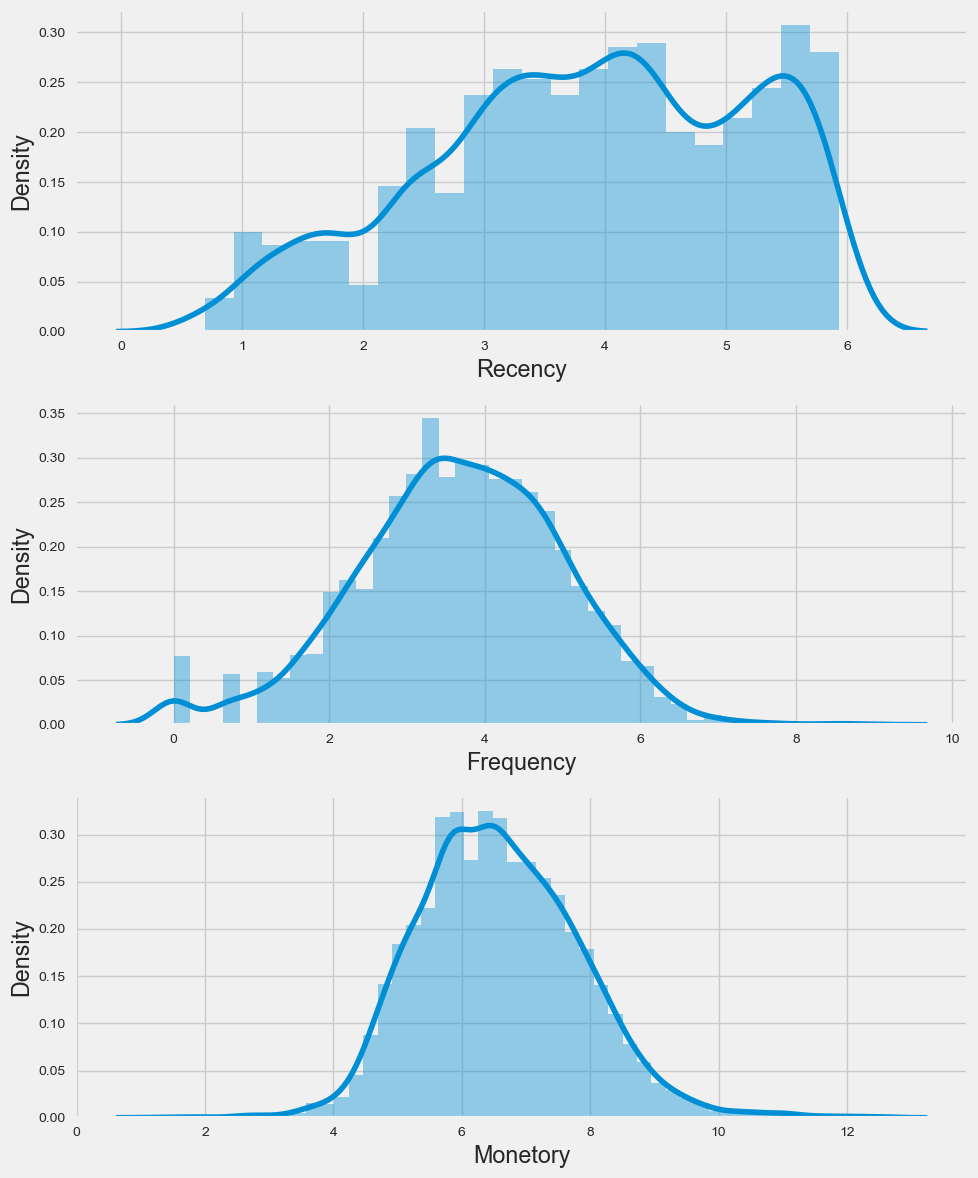

In [72]:
#Unskew the data with log transformation
rfm_log = RFM_DataFrame[['Recency', 'Frequency', 'Monetory']].apply(np.log, axis = 1).round(3)
#or rfm_log = np.log(rfm_rfm)


# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.Monetory, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [71]:
RFM_DataFrame=RFM_DataFrame[RFM_DataFrame["Monetory"]>0]

## K-Means clustering Algorithm
### Steps ;
#### 1 Data Pre Processing
#### 2 Choosing the number of clusters
#### 3 Running K-means clustering on pre-processed data
#### 4 Analyzing average RFM values of each cluster


###### 1 DATA PRE_PRECESSING

In [74]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
#Store it separately for clustering
rfm_normalized= scaler.transform(rfm_log)

In [76]:
rfm_normalized

array([[ 1.47894311, -2.78052248,  3.70023933],
       [-1.89088894,  1.16038982,  1.41349442],
       [ 0.37249962, -0.18000502,  0.71994094],
       ...,
       [-1.27033176, -0.8986687 , -1.11262551],
       [-1.72025484,  2.20317158,  0.82219054],
       [-0.05599856,  0.43642515,  0.73737886]])

#### 2 Choosing the number of culesters
###### Methods to define the number of clusters

###### Visual methods - elbow criterion
###### Mathematical methods - silhouette coefficient
###### Experimentation and interpretation
###### Elbow criterion method

###### Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
###### Identify an "elbow" in the plot
###### Elbow - a point representing an "optimal" number of clusters

In [78]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [79]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,8))

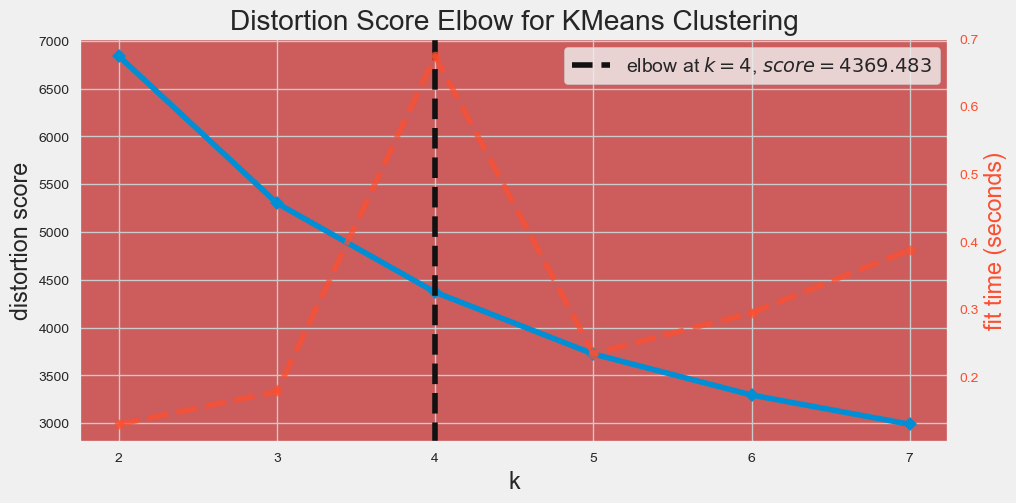

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [80]:
plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")
visualizer.fit(rfm_normalized)
visualizer.show()


In [82]:
# clustering , k=4
kc = KMeans(n_clusters= 4, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = RFM_DataFrame.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'Monetory': ['mean', 'count'],}).round(0)

Recency Frequency Monetory      
             mean      mean     mean count
K_Cluster                                 
0           188.0      14.0    281.0  1300
1            15.0     271.0   6820.0   912
2           107.0      75.0   1451.0  1193
3            23.0      40.0    612.0   933

<AxesSubplot:xlabel='Monetory', ylabel='Frequency'>

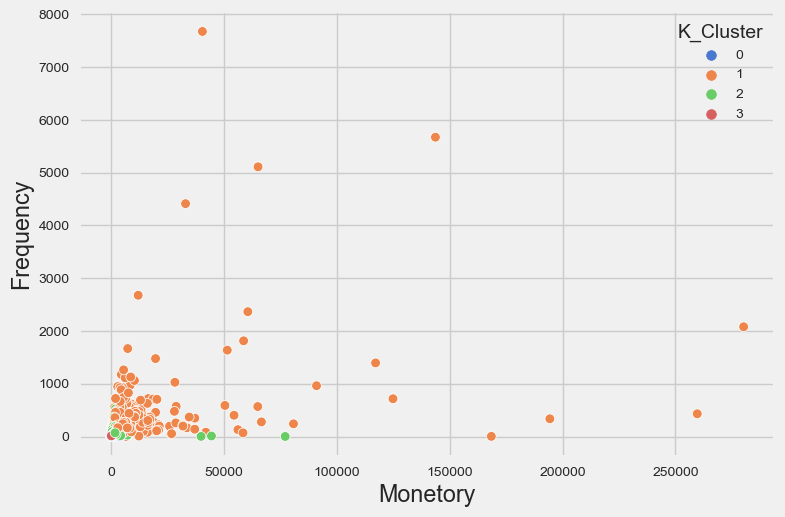

In [89]:
sns.scatterplot(data=rfm_rfm_k3,x="Monetory",y="Frequency",hue="K_Cluster",palette='muted')

## Conclusion: We talked about how to get RFM values from customer purchase data, and we made two kinds of segmentation with RFM quantiles and K-Means clustering methods.